# AutoEncoder
- *Autoencoder* is an unsupervised approach for learning the low-dimensional latent representation of the inputs
- useful application of autoencoder
   1. feature extraction
   2. unsupervised pretraining
   3. dimensionality reduction
   4. generative models
   5. anomalty detection -- autoencoder is generally bad a recosntructing outliers

- How to use autoencoder to pretrain network using unsupervised learning
If you want to train a classifier and you have plenty of unlabelled training data but only a few thousand labelled instances, then you could first train a deep autoencoder on the fulldataset(labeled + unlabelled), then reuse its lower half for the classifier(encoder) and train the classifier using the labeld data. We are using autoencoder as a feature extraction tool. The output of the encoder would have much lower dimension so it would have a lot less weights to train. If you have a little labeled data, you probability want to freeze the reused layers when training the classifier.

-If we do not constrain the network, it will end up memorizing the input rather than learning any useful pattern in the training data.



## Example of using autoencoder on MNIST dataset

### Import dependencies

In [37]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Flatten,Dense, Input, Dropout

import matplotlib.pyplot as plt

import numpy as np

print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

tensorflow version: 2.2.0
keras version: 2.3.0-tf


### Exploratory Data Analysis

In [0]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X_data, Y_data = fetch_openml(name='mnist_784', return_X_y=True, cache=False)

In [3]:
X_data = X_data /255.

X_train, X_val, y_train, y_val = train_test_split(X_data, Y_data, test_size = 0.1, random_state=42)
print(f"Size of training set: {len(X_train)}")
print(f"Size of validation set: {len(X_val)}")


Size of training set: 63000
Size of validation set: 7000


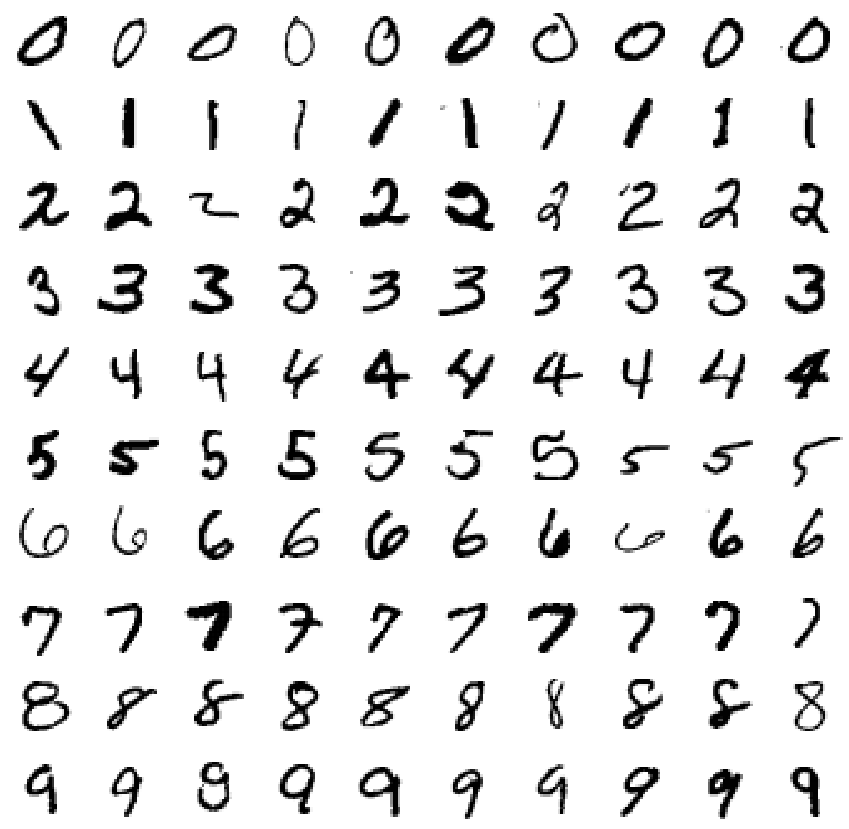

In [6]:
#visualize a few
number_of_digits = 10
num_examples = 10
plt.rcParams['image.cmap'] = "binary"
plt.rcParams['figure.figsize'] = [15,15]
fig, axes_list = plt.subplots(10,10)
for target_digit in range(number_of_digits):
    dataset = X_train[y_train == str(target_digit)][:num_examples]
    for i in range(num_examples):
        axes_list[target_digit,i].imshow(dataset[i].reshape(28,28),interpolation="nearest")
        axes_list[target_digit,i].axis("off")

### Using stacked autoencoder(has multiple hidden layer)

In [0]:
#encoder 
stacked_encoder = keras.models.Sequential()
stacked_encoder.add(Input(shape=784))
stacked_encoder.add(Dense(units=100,  activation="selu"))  #SELU activation 
stacked_encoder.add(Dense(units=30, activation="selu"))

#decoder
stacked_decoder = keras.models.Sequential()
stacked_decoder.add(Input(shape=30))
stacked_decoder.add(Dense(units=100, activation="selu"))
stacked_decoder.add(Dense(units=784, activation="sigmoid"))

#stacked autoencoder 
stacked_ae = keras.models.Sequential()
stacked_ae.add(stacked_encoder)
stacked_ae.add(stacked_decoder)

In [12]:
#compile it
stacked_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5))
#train it
history = stacked_ae.fit(X_train,X_train, epochs=10, validation_data=(X_val,X_val))

Epoch 1/10
1969/1969 [==============================] - 5s 2ms/step - loss: 0.1054 - val_loss: 0.1044
Epoch 2/10
1969/1969 [==============================] - 5s 2ms/step - loss: 0.1038 - val_loss: 0.1034
Epoch 3/10
1969/1969 [==============================] - 5s 2ms/step - loss: 0.1027 - val_loss: 0.1018
Epoch 4/10
1969/1969 [==============================] - 5s 2ms/step - loss: 0.1016 - val_loss: 0.1025
Epoch 5/10
1969/1969 [==============================] - 5s 2ms/step - loss: 0.1007 - val_loss: 0.1011
Epoch 6/10
1969/1969 [==============================] - 5s 2ms/step - loss: 0.0993 - val_loss: 0.0988
Epoch 7/10
1969/1969 [==============================] - 5s 2ms/step - loss: 0.0983 - val_loss: 0.0985
Epoch 8/10
1969/1969 [==============================] - 5s 2ms/step - loss: 0.0976 - val_loss: 0.0968
Epoch 9/10
1969/1969 [==============================] - 5s 2ms/step - loss: 0.0966 - val_loss: 0.0965
Epoch 10/10
1969/1969 [==============================] - 5s 2ms/step - loss: 0.095

### Visualizing the reconstructions

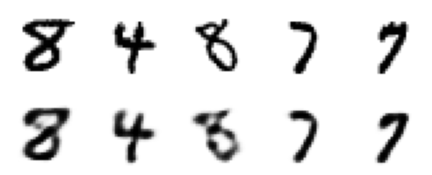

In [15]:
def plot_image(image):
    plt.imshow(image.reshape(28,28), cmap="binary")
    plt.axis("off")

def show_reconstructions(model, n_images=5):
    reconstructions = model.predict(X_val[:n_images])
    fig = plt.figure(figsize=(n_images*1.5,3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1+image_index) #(nrows,ncols, index)
        plot_image(X_val[image_index])
        plt.subplot(2, n_images, 1+image_index + n_images) #next row by adding n_images
        plot_image(reconstructions[image_index])

show_reconstructions(stacked_ae)

### Using the encoder and TSNE(other dimension reduction technique) for visualization

In [0]:
X_val_compressed = stacked_encoder.predict(X_val)
tsne = TSNE()
X_val_2D = tsne.fit_transform(X_val_compressed)

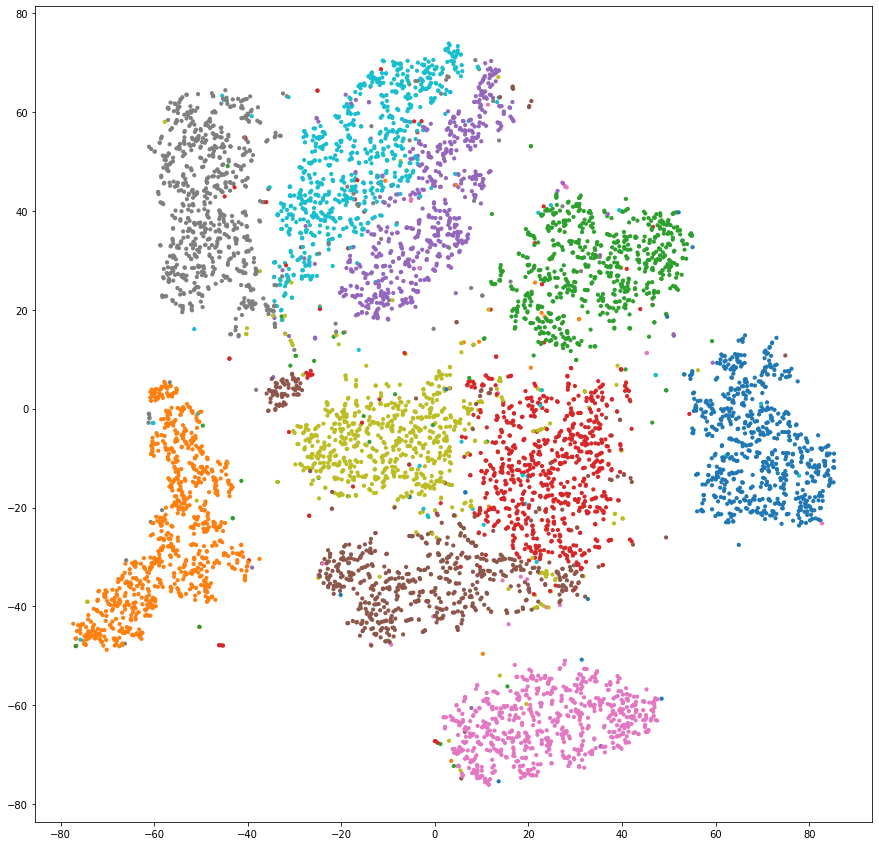

In [21]:
plt.scatter(X_val_2D[:,0],X_val_2D[:,1], c=y_val.astype(int),s=10, cmap="tab10")

### Unsupervised pretrainined using stacked autoencoders

If you are tackling a complex supervised task but you do not have a lot of labelled dataset, one solution is to find a nn that performs a similar task and reuse its lower layers. This works since your neural network won't have to learn all the low-level features; it can reuse the feature detectors learned by the existing network. In a way, it is transfer-learning since we are re-using the feature detectors trained on much bigger network.

You can train a stacked autoencoder using all the dataset(labeled + unlabeled) and use the encoder layers to create a NN for your actual task and train it using the labeled data. You can choose to finetune the lower layers depending on the size of your labeled dataset.

### Technique for training stacked autoencoders

#### 1. Tying weights
If the architectur of the autoencoder, we can tie the weights of the decoder layers to the weights of the decoder layers to the weights of the encoder layer. This halves the number of weights in the model, speeding upt he training and reducing the risk of overfitting.

In [0]:
#define a custom layer
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",initializer="zeros", shape=[self.dense.input_shape[-1]])
        super().build(batch_input_shape)

    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True) #uses another layers weights  
        return self.activation(z+self.biases) #uses its own biases

In [0]:
# new stacked autoencoder using tied weights
dense_1 = Dense(100, activation="selu")
dense_2 = Dense(30, activation="selu")

tied_encoder = keras.models.Sequential()
tied_encoder.add(Input(shape=784))
tied_encoder.add(dense_1)
tied_encoder.add(dense_2)

tied_decoder = keras.models.Sequential([DenseTranspose(dense_2, activation="selu"),
                                        DenseTranspose(dense_1, activation="sigmoid")])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])


In [33]:
#compile it
tied_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5))
#train it
history = tied_ae.fit(X_train,X_train, epochs=10, validation_data=(X_val,X_val))

Epoch 1/10
1969/1969 [==============================] - 5s 2ms/step - loss: 0.1498 - val_loss: 0.1154
Epoch 2/10
1969/1969 [==============================] - 5s 2ms/step - loss: 0.1091 - val_loss: 0.1042
Epoch 3/10
1969/1969 [==============================] - 5s 2ms/step - loss: 0.1027 - val_loss: 0.1121
Epoch 4/10
1969/1969 [==============================] - 5s 2ms/step - loss: 0.0996 - val_loss: 0.0989
Epoch 5/10
1969/1969 [==============================] - 5s 2ms/step - loss: 0.0978 - val_loss: 0.0971
Epoch 6/10
1969/1969 [==============================] - 5s 2ms/step - loss: 0.0964 - val_loss: 0.0954
Epoch 7/10
1969/1969 [==============================] - 5s 3ms/step - loss: 0.0954 - val_loss: 0.0947
Epoch 8/10
1969/1969 [==============================] - 5s 3ms/step - loss: 0.0944 - val_loss: 0.0943
Epoch 9/10
1969/1969 [==============================] - 5s 2ms/step - loss: 0.0936 - val_loss: 0.0932
Epoch 10/10
1969/1969 [==============================] - 5s 2ms/step - loss: 0.093

## Convolutional Autoencoder

## Recurrent AutoEncoder

# Denoising Autoencoder

We can add noise to the trianing dataset, and train the autoencoder to recover the original, noise-free inputs

In [0]:
dropout_encoder = keras.models.Sequential([
    Input(shape=[784]),
    Dropout(0.5),
    Dense(100,activation="selu"),
    Dense(30, activation="selu")
])

dropout_decoder = keras.models.Sequential([
    Input(shape=[30]),
    Dense(100, activation="selu"),
    Dense(784, activation="sigmoid")
])

dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])

In [42]:
#compile it
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5))
#train it
history = dropout_ae.fit(X_train,X_train, epochs=10, validation_data=(X_val,X_val))

Epoch 1/10
1969/1969 [==============================] - 5s 3ms/step - loss: 0.1920 - val_loss: 0.1475
Epoch 2/10
1969/1969 [==============================] - 5s 3ms/step - loss: 0.1517 - val_loss: 0.1350
Epoch 3/10
1969/1969 [==============================] - 5s 3ms/step - loss: 0.1435 - val_loss: 0.1294
Epoch 4/10
1969/1969 [==============================] - 5s 3ms/step - loss: 0.1386 - val_loss: 0.1264
Epoch 5/10
1969/1969 [==============================] - 5s 3ms/step - loss: 0.1349 - val_loss: 0.1223
Epoch 6/10
1969/1969 [==============================] - 5s 3ms/step - loss: 0.1320 - val_loss: 0.1201
Epoch 7/10
1969/1969 [==============================] - 5s 2ms/step - loss: 0.1297 - val_loss: 0.1186
Epoch 8/10
1969/1969 [==============================] - 5s 2ms/step - loss: 0.1278 - val_loss: 0.1167
Epoch 9/10
1969/1969 [==============================] - 5s 2ms/step - loss: 0.1258 - val_loss: 0.1152
Epoch 10/10
1969/1969 [==============================] - 5s 2ms/step - loss: 0.123

### Sparsity autoencoder
Use penalty term to force the autoencoder to use less number of active neurons